En este trabajo, extraemos cuentos de cuatro autores (Arredondo, Borges, Cortázar y Lispector) de una página web, Ciudad Seva (https://ciudadseva.com/biblioteca/indice-autor-cuentos/). Para cada cuento, generamos un vector utilizando el modelo fasttext y con él medimos la distancia semántica a cuentos del propio autor y a los de otros autores. Luego comparamos ambas medidas. Además, hacemos un análisis de los tópicos de los cuentos para cada autor.

0) Instalar bs4 e importar las bibliotecas

In [ ]:
!pip install beautifulsoup4 #ejecutar esto una sola vez

import requests
from bs4 import BeautifulSoup
import time

!pip install fasttext
import fasttext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 3.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pybind11-2.13.6-py3-none-any.whl.metadata (9.5 kB)
Using cached pybind11-2.13.6-py3-none-any.whl (243 kB)
  Created wheel for fasttext: filename=fasttext-0.9.3-cp311-cp311-linux_x86_64.whl size=4313510 sha256=1081b0b0376657f02a40607056f07cbbcfa815389f1b5fcfed522d6b774bbed0
  Stored in directory: /root/.cache/pip/wheels/65/4f/35/5057db0249224e9ab55a513fa6b79451473ceb7713017823c3
Successfully built fasttext


1) Montar drive. Cambiar los paths de la carpeta y del modelo según cómo los tengas en tu drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#paths
# ft = fasttext.load_model('/content/drive/MyDrive/Colab/TallerNLP/cc.es.300.bin')  #Juli
ft = fasttext.load_model('/content/drive/MyDrive/TallerNLP/cc.es.300.bin')  #Eric
# carpeta = '/content/drive/MyDrive/Colab/TallerNLP/cuentos_para_analizar/' #Juli
carpeta = '/content/drive/MyDrive/TallerNLP/cuentos_para_analizar' #Eric

2) Las siguientes funciones se encargan de buscar los archivos de los autores, leerlos y "limpiar" el nombre de los cuentos para poder ser usados en el item 3.

Resultado: diccionario de la forma {autorx, lista de sus cuentos}.

Importante: Requiere que dentro de la carpeta cuentos_para_analizar los unicos archivos .txt que existan sean el de los autores de la forma "autorx.txt" y dentro de cada archivo esten los nombres de los cuentos uno por cada linea.

In [ ]:
import os
import glob

def limpiar_texto(lista:list[str])->list[str]:
    """
    Se encarga de limpiar los nombres de los cuentos para que sean aptos para vector_cuentos()

    Entrada: lista_cuentos (list[str]), lista_cuentos = archivo.readlines() de los archivos con los cuentos de los autores

    Salida: lista con los nombres de los cuentos validos para vector_cuentos
    """
    char_a_reemplazar:dict[str,str] = {'ñ':'n','á':'a','é':'e','í':'i','ó':'o','ú':'u','\n':'',' ':'-','ã':'a','"':'','(':'',')':'','ä':'a','ë':'e','ï':'i','ö':'o','ü':'u',"'":""}
    res:list[str] = []
    for elemento in lista:
        aux:str = ""
        for letra in elemento:
            letra = letra.lower()
            if letra not in char_a_reemplazar.keys():
                aux += letra
            else:
                aux += char_a_reemplazar[letra]
        if len(aux)>0:
          res.append(aux.lower())
    return res

def obtener_autores(archivos_autores:list[str],carpeta:str)->list[str]:
    """
    Dada la lista de los archivos existentes, extrae el nombre del autor.
    Requiere que los unicos archivos dentro de la carpeta "cuentos_para_analizar" sean de la forma "autor.txt"
    y contenga los nombres de los cuentos, cada cuento en una linea del archivo

    Entrada: carpeta, donde estan los archivos (str).
    archivos_autores, con los archivos encontrados dentro de la carpeta (lista de str)

    Salida: lista con los nombres de los autores, extraidos de los archivos.
    """
    #hice de tres formas distintas las tres me andan a mi
    #esta es la primera forma
    """
    res:list[str] = []
    for dir_archivo in archivos_autores:
        autor:str = dir_archivo[len(carpeta):-4] #esto es lo que genero problemas
        res.append(autor) #para que no aparezca la barra al principio
    return res"""
    #esta es la segunda forma que probe
    """res:list[str] = []
    for dir_archivo in archivos_autores:
        autor:str = (dir_archivo.split("/")[-1])[0:-4]
        res.append(autor) #para que no aparezca la barra al principio
    return res"""
    #esto me lo hizo chatgpt
    return [os.path.splitext(os.path.basename(archivo))[0] for archivo in archivos_autores if archivo.endswith(".txt")]

def cargar_nombres_cuentos(carpeta:str):
    """
    Dada una carpeta, busca los archivos de autores existentes guardando sus direcciones en una lista.
    Crea un diccionario de la forma {autor:lista_cuentos},
    obteniendo el nombre del autor usando obtener_autores y la lista_cuentos leyendo cada archivo y limpiando su texto con limpiar_cuentos

    Requiere que dentro de la carpeta los unicos archivos .txt existentes sean de la forma "autorx.txt"
    y su contenido sea linea por linea nombre de cuento, con cada linea con solo un cuento

    Entrada: carpeta (str).

    Salida: diccionario de la forma {autor:lista_cuentos_valida}, siendo lista_cuento_valida la lista con cuentos ya limpia para luego cada elemento ser utilizado en vector_cuento().
    """
    dicc:dict[str,list[str]] = {}
    archivos_txt:list[str] = glob.glob(os.path.join(carpeta, "*.txt")) #busca que archivos de texto hay en la carpeta
    autores:list[str] = obtener_autores(archivos_txt,carpeta)
    for i in range(0, len(archivos_txt)):
    #for i in range(0, 2):
        archivo = open(archivos_txt[i],"r", encoding="utf-8")
        dicc[autores[i]] = limpiar_texto(archivo.readlines())
        archivo.close()
    return dicc

dicc = cargar_nombres_cuentos(carpeta)
print(dicc)

{'cortazar': ['alguien-que-anda-por-ahi', 'almuerzos', 'amor-77', 'apocalipsis-de-solentiname', 'axolotl', 'bestiario', 'carta-a-una-senorita-en-paris', 'cartas-de-mama', 'casa-tomada', 'cefalea', 'circe', 'condor-y-cronopio', 'conducta-en-los-velorios', 'conservacion-de-los-recuerdos', 'continuidad-de-los-parques', 'cortisimo-metraje', 'datos-para-entender-a-los-perqueos', 'desayuno', 'deshoras', 'despues-del-almuerzo', 'educacion-de-principe', 'el-diario-a-diario', 'el-otro-cielo', 'el-perseguidor', 'en-un-vaso-de-agua-fria-o-preferentemente-tibia', 'epigrafe-de-rayuela', 'eugenesia', 'final-del-juego', 'grafitti', 'historia', 'historia-veridica', 'instrucciones-para-cantar', 'instrucciones-para-dar-cuerda-al-reloj', 'instrucciones-para-john-howell', 'instrucciones-para-llorar', 'instrucciones-para-subir-una-escalera', 'la-autopista-del-sur', 'la-caricia-mas-profunda', 'la-fe-en-el-tercer-mundo', 'la-isla-a-mediodia', 'la-noche-boca-arriba', 'la-puerta-condenada', 'la-salud-de-los-en

3) A partir de todas las funciones anteriores y la celda de más abajo queremos guardar un diccionario {autorx:list[embedding_del_cuento]} y otro {autorx:list[cuento]} en la carpeta compartida

In [ ]:
def limpiar_html(texto) -> str:
    limpio = "\n\n".join(el.get_text(strip=True) for el in texto)
    return limpio

def vector_cuento(nombre_cuento,autor):
    """
    Con el nombre del cuento, entra a Ciudad Seva, extrae y limpia el texto del cuento.
    Luego pasa el texto a un vector y lo devuelve.

    Entrada: nombre de un cuento (str).

    Salida: embedding (vector) del cuento o None si hay una falla.
    """
    time.sleep(2)
    response = requests.get('https://ciudadseva.com/texto/' + nombre_cuento)
    if response.status_code != 200:
        print(f"Error en la conexión: {response.status_code}")
        return None

    soup = BeautifulSoup(response.text, "html.parser")

    # Locate the <article> with class including both "post-" and "texto"
    article = soup.find("article", class_=lambda x: x and "post-" in x and "texto" in x)
    if not article:
        print("Error. No se encontró el artículo")
        return None

    # Extract all relevant tags (e.g., paragraphs, headers, etc.)
    texto_completo = article.find_all(["p", "h1", "h2", "h3", "h4", "h5", "h6", "div", "blockquote"])
    # titulo = limpiar_html(texto_completo[0]).split('[')[0].strip()
    # autor = limpiar_html(texto_completo[0]).split(']')[-1].split('\n')[-1]
    #cuento = limpiar_html(texto_completo[3:-2].replace('\n',''))
    #print(limpiar_html(texto_completo[0]).split(']')[-1].split('\n')[-1])
    if autor !=limpiar_texto(limpiar_html(texto_completo[0]).split(']')[-1].split('\n')[-1].split(' '))[-1].lower():
      if nombre_cuento[len(nombre_cuento)-len(autor): len(nombre_cuento)] != autor:
        return vector_cuento(str(nombre_cuento+"-"+autor),autor)
      """else:
        print("hola",str(nombre_cuento[0:len(nombre_cuento)-len(autor)-1]+"-2"),autor)
        return vector_cuento(str(nombre_cuento+"-2"),autor)"""

    #cuento = texto_completo[3:-2]
    cuento = limpiar_html(texto_completo[3:-2]).replace('\n', ' ')
    vector = ft[cuento]
    return vector, cuento

"""
def cargar_diccionario_con_embedings(dicc):
    res = {}
    for autor in dicc.keys():
        lista_embedings = []
        for cuento in dicc[autor]:
            lista_embedings.append(vector_cuento(cuento))
        res[autor] = lista_embedings
    return res


res = cargar_diccionario_con_embedings(dicc)"""

vectores_por_autor = {}
cuentos_no_encontrados = []
autor_cuentos = {a:[] for a in dicc.keys()}
for autor, cuentos in dicc.items():
    vectores = []
    for cuento in cuentos:
        try:
            vector, texto = vector_cuento(cuento,autor)
            vectores.append(vector)
            autor_cuentos[autor].append(texto)
        except:
            print(f"❌ No se pudo obtener vector para '{cuento}' de {autor}")
            cuentos_no_encontrados.append((autor,cuento))
    vectores_por_autor[autor] = vectores

import pickle

#guardamos los diccionarios
with open('/content/drive/MyDrive/TallerNLP/vectores_autores.pkl', 'wb') as f:
    pickle.dump(vectores_por_autor, f)

with open('/content/drive/MyDrive/TallerNLP/autor_cuentos.pkl', 'wb') as f:
    pickle.dump(autor_cuentos, f)

Error en la conexión: 404
❌ No se pudo obtener vector para 'el-adivino' de borges
Error en la conexión: 404
❌ No se pudo obtener vector para 'silencio' de lispector
[('borges', 'el-adivino'), ('lispector', 'silencio')]


# Si ya tenemos el diccionario de vectores armado, lo cargamos y procedemos a hacer el análisis de distancias

Lo primero que podemos hacer es ver si la distancia semántica dentro de los cuentos de un mismo autorx es más chica que la distancia semántica entre esos cuentos y los del resto de lxs autores. Por convención, a la primera vamos a llamarla distancia **intra** y a la segunda, **inter**. Si se cumple lo esperado, en promedio deberíamos tener una distancia semántica intra menor a la inter. Vamos a probar con distancia coseno y con distancia euclidiana.

In [ ]:
from scipy.spatial.distance import pdist
from scipy.spatial import distance
import numpy as np
import pickle
from google.colab import drive
drive.mount('/content/drive')

ruta = '/content/drive/MyDrive/Colab/TallerNLP/vectores_autores.pkl' #ruta Juli:
ruta = '/content/drive/MyDrive/TallerNLP/vectores_autores.pkl' #ruta Eric

with open(ruta, 'rb') as f:
    autores_por_vector = pickle.load(f)

def distancia_intra(lista_vectores, distancia_coseno=True):
    X = np.array(lista_vectores)
    if distancia_coseno:
        metric = 'cosine'
    else:
        metric = 'euclidean'
    dists = pdist(X, metric=metric)

    return np.mean(dists)

def distancia_inter(diccionario_autores, autor, distancia_coseno=True):
    vectores_propios = np.array(diccionario_autores[autor])  # Shape: (n_sampleses_propios, dim)
    vectores_otros = np.array([x for xs in [diccionario_autores[a] for a in diccionario_autores.keys() if a != autor] for x in xs])
    vectores_otros = vectores_otros.reshape(-1, vectores_propios.shape[1])  # Shape: (n_samples_otros, dim)

    dist = 0
    if distancia_coseno:
        for v1 in vectores_propios:
            for v2 in vectores_otros:
                dist += distance.cosine(v1, v2)

    else:
        for v1 in vectores_propios:
            for v2 in vectores_otros:
                dist += np.linalg.norm(v1 - v2)

    combinaciones = vectores_propios.shape[0] * vectores_otros.shape[0]
    return dist/combinaciones

distancias_autores = {a:{'intra':0, 'inter':0} for a in autores_por_vector.keys()}
for autor in autores_por_vector.keys():
    distancias_autores[autor]['intra'] = distancia_intra(autores_por_vector[autor], distancia_coseno=False)
    distancias_autores[autor]['inter'] = distancia_inter(autores_por_vector, autor, distancia_coseno=False)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


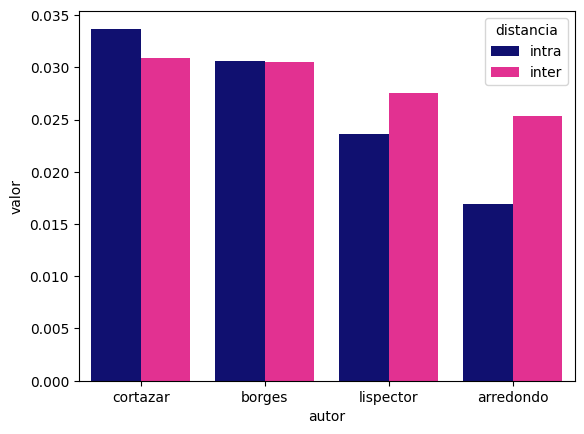

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame.from_dict(distancias_autores).T
df['autor'] = df.index
df2 = df.melt(id_vars='autor', value_vars=['intra','inter'], var_name='distancia', value_name='valor')
orden = ['intra', 'inter']
ax = sns.barplot(data=df2, x='autor', y='valor', hue='distancia',
    palette={'intra': 'navy', 'inter': 'deeppink'}, hue_order=orden)
plt.show()

# Análisis de tópicos

Este es un análisis basado únicamente en los textos de los cuentos y no en sus vectores. Lo que vamos a hacer es extraer los tópicos o palabras más frecuentes en los textos de cada autorx. Para esto, primero se van a eliminar las *stop words*, que son palabras como "el", "la", "de", "con", etc. que no tienen ninguna importancia en este análisis.

Para correr esto, necesitaríamos el diccionario {autorx: list[cuento]} previamente armado

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import nltk
from nltk.corpus import stopwords
import re

nltk.download('stopwords')
spanish_stopwords = stopwords.words('spanish')

def limpiar_texto(texto):
    """Lowercase, remove non-alphabetic, and tokenize."""
    texto = texto.lower()
    texto = re.sub(r'[^a-záéíóúüñ\s]', '', texto)
    return texto

def extraer_topicos(dic_autor_cuentos, n_components=5, n_words=10):
    resultados = {}

    for autor, historias in dic_autor_cuentos.items():
        # Combina todos los cuentos
        texto_autor = limpiar_texto(" ".join(historias))
        partes = texto_autor.split('.')
        docs = [p.strip() for p in partes if len(p.strip().split()) > 5]

        if len(docs) < n_components:
            docs = [texto_autor]

        vectorizer = TfidfVectorizer(stop_words=spanish_stopwords, max_features=5000)
        X = vectorizer.fit_transform(docs)
        vocab = vectorizer.get_feature_names_out()

        svd = TruncatedSVD(n_components=n_components, random_state=42)
        svd.fit(X)

        # Palabras más frecuentes por tópico
        topics = []
        for comp in svd.components_:
            top_indices = comp.argsort()[::-1][:n_words]
            top_words = [vocab[i] for i in top_indices]
            topics.append(top_words)

        resultados[autor] = topics

    return resultados

ruta = '/content/drive/MyDrive/Colab/TallerNLP/autor_cuentos.pkl' #ruta Juli:
ruta = '/content/drive/MyDrive/TallerNLP/autor_cuentos.pkl' #ruta Eric

with open(ruta, 'rb') as f:
    autor_cuentos = pickle.load(f)
topicos_autores = extraer_topicos(autor_cuentos)
for autor in autor_cuentos:
    print(f'Tópicos más frecuentes en {autor}: {topicos_autores[autor]}')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Tópicos más frecuentes en cortazar: [['si', 'vez', 'tan', 'dos', 'dijo', 'después', 'casi', 'ahora', 'bien', 'mamá']]
Tópicos más frecuentes en borges: [['hombre', 'si', 'dos', 'dijo', 'vez', 'noche', 'hombres', 'tiempo', 'después', 'ahora']]
Tópicos más frecuentes en lispector: [['si', 'entonces', 'vez', 'ser', 'ojos', 'solo', 'tan', 'huevo', 'dijo', 'mujer']]
Tópicos más frecuentes en arredondo: [['si', 'ojos', 'casa', 'tan', 'vez', 'madre', 'ahora', 'ser', 'así', 'dijo']]
